## Data Downloading and preprocessing

In [1]:
# @title Kaggle Competition Data Downloading  { display-mode: "form",run :"auto" }
# @markdown Put the competition name
kaggle_username = 'Kaggle_Username'     # @param ['Kaggle_Username', 'kaggle_username', 'kaggle_2']
kaggle_token = "Kaggle"     # @param ["Kaggle", 'kaggle', 'kaggle_2_pass']

project_name = 'playground-series-s4e9'  # @param {type: "string"}


from google.colab import userdata
from IPython import display
import os
token = {"username":userdata.get(kaggle_username),"key":userdata.get(kaggle_token)}
import os, json
os.environ['KAGGLE_CONFIG_DIR']='.'
with open('kaggle.json', "w") as f:
    json.dump(token, f)
!chmod 600 ./kaggle.json
!kaggle competitions download -c $project_name
filename = project_name + ".zip"
!unzip $project_name && rm $filename
os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('MLFLOW_TRACKING_PASSWORD')
os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('MLFLOW_TRACKING_USERNAME')
display.clear_output()
print("Files have been downloaded!")

Files have been downloaded!


In [2]:
!kaggle datasets download taeefnajib/used-car-price-prediction-dataset && unzip *.zip && rm -d *.zip

Dataset URL: https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
  0% 0.00/109k [00:00<?, ?B/s]
100% 109k/109k [00:00<00:00, 51.2MB/s]
Archive:  used-car-price-prediction-dataset.zip
  inflating: used_cars.csv           


In [3]:
!pip install optuna-dashboard optuna
!pip install mlflow dagshub flaml
!pip install catboost
!mkdir -p output/models output/logs output/plots
!pip install --upgrade gdown
display.clear_output()
import dagshub
import mlflow
import optuna

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import anderson,kstest, shapiro
from IPython.display import Audio,display as dis
from IPython.display import clear_output

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge

In [5]:
# Classification
from sklearn.metrics import (confusion_matrix, accuracy_score,
                             precision_score, f1_score, recall_score,
                             roc_auc_score, roc_curve, auc
                             )
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import VALID_METRICS

from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, ExtraTreesClassifier,
                              BaggingClassifier, RandomForestClassifier,
                              GradientBoostingClassifier,
                              HistGradientBoostingClassifier,
                              StackingClassifier
                              )
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from catboost import CatBoostClassifier

# Regression Models
from sklearn.metrics import (mean_squared_error, r2_score,)
from sklearn.metrics import mean_squared_error
# 'neg_root_mean_squared_log_error'
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import VALID_METRICS

from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor
from sklearn.ensemble import (AdaBoostRegressor, ExtraTreesRegressor,
                              BaggingRegressor, RandomForestRegressor,
                              GradientBoostingRegressor,
                              HistGradientBoostingRegressor,
                              StackingRegressor
                              )
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from catboost import CatBoostRegressor

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [6]:
# plotly libraries setup
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = "colab"
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
# import plotly.offline as pyo
# pyo.init_notebook_mode()

In [111]:
dagshub.init("Kaggle-Competitions-Lab", "SantanuK", mlflow=True)
experiment_name = 'Regression of Used Car Prices'
try:
    mlflow.create_experiment(experiment_name)
    mlflow.set_experiment(experiment_name)
except Exception as e:
    mlflow.set_experiment(experiment_name)
    # print("Experiment has been created or some issue occured!\n","Error: ", e )

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=6a9fafe0-da2b-4395-b4be-0ca04e15a0f4&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=272cd4770a7a29be5397518bed68db5b1f002b2c66af09e82d161c6d7863e633




Accessing as SantanuK

Initialized MLflow to track repo "SantanuK/Kaggle-Competitions-Lab"

Repository SantanuK/Kaggle-Competitions-Lab initialized!

In [75]:
df_train = pd.read_csv('train.csv').drop('id',axis=1)
df_test = pd.read_csv('test.csv').drop('id',axis=1)
df_extra = pd.read_csv('used_cars.csv')

In [9]:
print(f"""The number of features: {df_test.shape[1]}
-----------------
Training DataSet
-----------------
The number of samples:              {df_train.shape[0]}
The number of duplicated samples:   {df_train.duplicated().sum()}
The number of null samples:         {df_train.isna().sum().sum()} ({round(df_train.isna().sum().sum()/df_train.shape[0]*100,2)}%)
The number of unique samples:       {df_train.nunique().sum()}

-----------------
Testing DataSet
-----------------
The number of samples:              {df_test.shape[0]}
The number of duplicated samples:   {df_test.duplicated().sum()}
The number of null samples:         {df_test.isna().sum().sum()}({round(df_test.isna().sum().sum()/df_test.shape[0]*100,2)}%)
The number of unique samples:       {df_test.nunique().sum()}

""")

The number of features: 11
-----------------
Training DataSet
-----------------
The number of samples:              188533
The number of duplicated samples:   0
The number of null samples:         28954 (15.36%)
The number of unique samples:       11862

-----------------
Testing DataSet
-----------------
The number of samples:              125690
The number of duplicated samples:   0
The number of null samples:         19254(15.32%)
The number of unique samples:       9334




In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
dtypes: int64(3), object(9)
memory usage: 17.3+ MB


1. `fuel_trype`, `accident`, `clean_title` have null values.

In [76]:
try:
    df_train.drop('clean_title',axis=1,inplace=True)
    df_test.drop('clean_title',axis=1,inplace=True)
    df_extra.drop('clean_title',axis=1,inplace=True)
except:
    pass

In [21]:
df_train.isna().sum()
# df_extra.isna().sum()

,0
brand,0
model,0
model_year,0
milage,0
fuel_type,0
engine,0
transmission,0
ext_col,0
int_col,0
accident,0


In [77]:
df_train['fuel_type'] = df_train['fuel_type'].fillna('Electric')
df_extra['fuel_type'] = df_extra['fuel_type'].fillna('Electric')
df_test['fuel_type'] = df_test['fuel_type'].fillna('Electric')

In [78]:
df_train['accident'] = df_train['accident'].fillna('Unknown')
df_extra['accident'] = df_extra['accident'].fillna('Unknown')
df_test['accident'] = df_test['accident'].fillna('Unknown')

In [79]:
# df_train['fuel_type'].value_counts()
# df_train[(df_train['fuel_type']=='–')&(df_train['engine']!='–')]

In [13]:
# df_test[(df_test['fuel_type']=='–')&(df_test['engine']!='–')]

In [14]:
# df_train[(df_train['brand']=='Tesla') & (df_train['fuel_type']!='Electric')]

In [80]:
import re
def extract_fuel_type(engine_str):
    d = { 'Gasoline Fuel': 'Gasoline', 'Flex Fuel': 'E85 Flex Fuel','Electric Fuel':'Electric','Hydrogen Fuel':'Hydrogen',
      'Gas/Electric Hybrid': 'Hybrid','Plug-In Electric/Gas': 'Plug-In Hybrid','Flexible Fuel':'E85 Flex Fuel',
      'Diesel':'Diesel','Gasoline':'Gasoline','Hybrid':'Hybrid',
    }
    if isinstance(engine_str, str):
        fuel_match = re.search(r"(Gasoline Fuel|Hydrogen Fuel|Gasoline|Hydrogen|Diesel|Diesel Fuel|Electric Fuel|Hybrid|Flex Fuel|Flexible Fuel|Plug-In Electric/Gas|Gas/Electric Hybrid)", engine_str)
        if fuel_match:
            return d[fuel_match.group(1)]
    return np.nan

def extract_hp(engine_str):
    if isinstance(engine_str, str):
        hp_match = re.search(r"\d+(\.\d+)HP", engine_str)
        if hp_match:
            return float(hp_match.group()[:-2])
            # return hp_match.group(1)
    return np.nan
def extract_litre(engine_str):
    if isinstance(engine_str, str):
        hp_match = re.search(r"(\d+\.\d+)(L| Liter| L)", engine_str)
        if hp_match:
            return float(hp_match.group(1))

    return np.nan

def extract_cylinder(engine_str):
    if isinstance(engine_str, str):
        hp_match = re.search(r"(V*\d+|I*\d+) Cylinder Engine", engine_str)
        hp_match_2 = re.search(r"(V-*\d+|I-*\d+)", engine_str)
        if hp_match:
            return str(hp_match.group(1))
        if hp_match_2:
            return str(hp_match_2.group())

    return np.nan
def extract_valves(engine_str):
    if isinstance(engine_str, str):
        hp_match = re.search(r"(\d+)V", engine_str)
        if hp_match:
            return float(hp_match.group(1))
    return np.nan


In [81]:
df_train['fuel_type_'] = df_train['engine'].apply(extract_fuel_type)
df_test['fuel_type_'] = df_test['engine'].apply(extract_fuel_type)
df_extra['fuel_type_'] = df_extra['engine'].apply(extract_fuel_type)

df_train['fuel_type_'] = df_train['fuel_type_'].fillna(df_train['fuel_type'])
df_test['fuel_type_'] = df_test['fuel_type_'].fillna(df_test['fuel_type'])
df_extra['fuel_type_'] = df_extra['fuel_type_'].fillna(df_extra['fuel_type'])

In [82]:
df_train['hp'] = df_train['engine'].apply(extract_hp)
df_test['hp'] = df_test['engine'].apply(extract_hp)
df_extra['hp'] = df_extra['engine'].apply(extract_hp)

In [83]:
df_train['liter'] = df_train['engine'].apply(extract_litre)
df_test['liter'] = df_test['engine'].apply(extract_litre)
df_extra['liter'] = df_extra['engine'].apply(extract_litre)

In [84]:
df_train['cylinder'] = df_train['engine'].apply(extract_cylinder)
df_test['cylinder'] = df_test['engine'].apply(extract_cylinder)
df_extra['cylinder'] = df_extra['engine'].apply(extract_cylinder)

In [85]:
df_train['valves'] = df_train['engine'].apply(extract_valves)
df_test['valves'] = df_test['engine'].apply(extract_valves)
df_extra['valves'] = df_extra['engine'].apply(extract_valves)

In [86]:
from collections import Counter
c = Counter()
for sent in df_train['engine'].unique():
    c = c+Counter(sent.split())
l = c.most_common()
_keys, _vals = zip(*l)
l=[i for i in _keys if not re.search(r'(\d+\.*\d+(HP|L|)|\d+|Liter)',i)]

In [87]:
engine_props=[
    'Cylinder', 'DOHC', 'Turbo', 'Hybrid', 'GDI', 'Straight', 'Flat',
    'Diesel', 'Twin', 'MPFI', 'PDI', 'OHV', 'SOHC', 'Flexible',
    'Supercharged', 'DDI', 'TFSI', 'Dual', 'Standard', 'Rotary',
    'Intercooled', 'Battery', 'GTDI', 'SC', 'SIDI', 'I-VTEC',
    'Premium', 'Unleaded', 'ULEV', 'TSI', 'T/C', 'AH', 'FR', 'RR',
    'AC'
 ]
def extract_properties(engine_str):
    return " ".join([i for i in engine_str.split() if i in set(engine_props)])

In [88]:
df_train['engine_props'] = df_train['engine'].apply(extract_properties)
df_test['engine_props'] = df_test['engine'].apply(extract_properties)
df_extra['engine_props'] = df_extra['engine'].apply(extract_properties)

In [89]:
import re

# Sample string
text = "172.0HP 1.6L V4 Cylinder Engine Gasoline Fuel"
# text = "2.0 Liter Turbo"
# Regular expression to extract the number
number = re.search(r"(V*\d+|I*\d+)( Cylinder Engine)", text)

# Extracting the number from the match object
if number:
    extracted_number = number.group(1)
    print(extracted_number)
else:
    print("No number found")


V4


In [90]:
# display the table
from IPython.display import display_html
props = 'style="display:inline;"'
x = df_train['fuel_type_'].value_counts(dropna=False).reset_index().style.set_table_attributes(props)\
                            .set_caption('Fuel type New').to_html()
y = df_train['fuel_type'].value_counts(dropna=False).reset_index().style.set_table_attributes(props)\
                            .set_caption('Fuel type Old').to_html()
display_html(x+y, raw = True)

,fuel_type_,count
0,Gasoline,168429
1,Electric,5574
2,E85 Flex Fuel,5502
3,Diesel,4187
4,Hybrid,3499
5,–,774
6,Plug-In Hybrid,552
7,Hydrogen,16
,fuel_type,count
0,Gasoline,165940


In [206]:
# df_train.drop('litre',axis=1,inplace=True)
# df_test.drop('litre',axis=1,inplace=True)
# df_extra.drop('litre',axis=1,inplace=True)

In [91]:
def extract_transmission_speed(transmission_str):
    if isinstance(transmission_str, str):
        if transmission_str=='Single-Speed Fixed Gear':
            return 1
        speed_match = re.search(r"(\d+)", transmission_str)
        if speed_match:
            return int(speed_match.group(1))
    return np.nan

In [92]:
df_train['transmission_speed'] = df_train['transmission'].apply(extract_transmission_speed)
df_test['transmission_speed'] = df_test['transmission'].apply(extract_transmission_speed)
df_extra['transmission_speed'] = df_extra['transmission'].apply(extract_transmission_speed)

In [93]:
transmission_props = ['A/T', 'w/Dual','Shift','M/T','Automatic','CVT',
                      'Auto-Shift','Manual','Overdrive', 'Variable','Mt',
                      'Electronically','At/Mt','DCT','CVT-F','F','AT']
def extract_transmission_props(transmission_str):
    result_text =  " ".join([i for i in transmission_str.split() if i in set(transmission_props)])
    if result_text == '':
        return 'Unknown'
    if result_text == 'CVT-F':
        return 'CVT F'
    if result_text in ['A/T','AT']:
        return 'Automatic'
    if result_text in ['Manual','Mt','M/T']:
        return 'Manual'
    if result_text=='Variable':
        return 'CVT'
    if result_text in ['At/Mt','w/Dual Shift','DCT Automatic']:
        return 'Automatic Manual'

    return result_text


In [94]:
df_train['transmission_props'] = df_train['transmission'].apply(extract_transmission_props)
df_test['transmission_props'] = df_test['transmission'].apply(extract_transmission_props)
df_extra['transmission_props'] = df_extra['transmission'].apply(extract_transmission_props)

In [95]:
# df_train['transmission_props'].value_counts()

In [96]:
df_train['comb_col'] = df_train['ext_col']+' '+df_train['int_col']
df_test['comb_col'] = df_test['ext_col']+' '+df_test['int_col']
df_extra['comb_col'] = df_extra['ext_col']+' '+df_extra['int_col']

In [97]:
df_train['age'] = 2024-df_train['model_year']
df_test['age'] = 2024-df_test['model_year']
df_extra['age'] = 2024-df_extra['model_year']
df_train['milage_per_year'] = df_train['milage']/(df_train['age']*365)
df_test['milage_per_year'] = df_test['milage']/(df_test['age']*365)
df_extra['milage'] = df_extra['milage'].str.replace(' mi.','').str.replace(',', '').astype(int)
df_extra['milage_per_year'] = df_extra['milage']/(df_extra['age']*365)

In [98]:
# for col in ['hp','liter','valves']:
#     df_train[col] = df_train[col].fillna()

In [99]:
# z = df_train['engine_props'].str.split(' ').map(len)

# df_train.loc[z==5,'engine_props']

In [66]:
cols = ['engine_props_0',	'engine_props_1',	'engine_props_2',	'engine_props_3',	'engine_props_4']
# df_train.drop(cols,axis=1,inplace=True)
# df_test.drop(cols,axis=1,inplace=True)
# df_extra.drop(cols,axis=1,inplace=True)
for col in cols:
    df_train[col] = 'Unknown'
    df_test[col] = 'Unknown'
    df_extra[col] = 'Unknown'

In [35]:
words_mapper = {}

In [100]:
for words in df_train['engine_props']:
    x = set()
    for i,word in enumerate(words.split()):
        j = i if words_mapper.get(word) is None else words_mapper[word]
        while j in x:
            j = (j+1)%5

        x.add(j)
        words_mapper[word] = j

In [102]:
# words_mapper

In [101]:
for i,words in enumerate(df_train['engine_props']):
    for word in words.split():
        df_train.loc[i,f'engine_props_{words_mapper[word]}'] = word
for i,words in enumerate(df_test['engine_props']):
    for word in words.split():
        df_test.loc[i,f'engine_props_{words_mapper[word]}'] = word
for i,words in enumerate(df_extra['engine_props']):
    for word in words.split():
        df_extra.loc[i,f'engine_props_{words_mapper[word]}'] = word

In [103]:
df_train['hp'].value_counts()
df_train[(df_train['model']=='Pathfinder SL')]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,price,fuel_type_,hp,liter,cylinder,valves,engine_props,transmission_speed,transmission_props,comb_col,age,milage_per_year,engine_props_1,engine_props_0,engine_props_2,engine_props_3,engine_props_4
150,Nissan,Pathfinder SL,2022,13000,Gasoline,284.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,CVT Transmission,Silver,Black,None reported,29995,Gasoline,284.0,3.5,V6,NaN,Cylinder,NaN,CVT,Silver Black,2,17.808219,Cylinder,nan,nan,nan,nan
1634,Nissan,Pathfinder SL,2014,135000,Gasoline,260.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,15900,Gasoline,260.0,3.5,V6,NaN,Cylinder,NaN,Automatic,Black Black,10,36.986301,Cylinder,nan,nan,nan,nan
2031,Nissan,Pathfinder SL,2018,52375,Gasoline,260.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,23995,Gasoline,260.0,3.5,V6,NaN,Cylinder,NaN,Automatic,Black Black,6,23.915525,Cylinder,nan,nan,nan,nan
3736,Nissan,Pathfinder SL,2018,76465,Gasoline,284.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,30000,Gasoline,284.0,3.5,V6,NaN,Cylinder,NaN,Automatic,White Beige,6,34.915525,Cylinder,nan,nan,nan,nan
3939,Nissan,Pathfinder SL,2014,154000,Gasoline,260.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Blue,Black,At least 1 accident or damage reported,10000,Gasoline,260.0,3.5,V6,NaN,Cylinder,NaN,Automatic,Blue Black,10,42.191781,Cylinder,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183154,Nissan,Pathfinder SL,2015,185000,Gasoline,284.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,CVT Transmission,White,Beige,At least 1 accident or damage reported,12000,Gasoline,284.0,3.5,V6,NaN,Cylinder,NaN,CVT,White Beige,9,56.316591,Cylinder,nan,nan,nan,nan
184314,Nissan,Pathfinder SL,2022,11102,Gasoline,284.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,83000,Gasoline,284.0,3.5,V6,NaN,Cylinder,NaN,Automatic,White Beige,2,15.208219,Cylinder,nan,nan,nan,nan
184682,Nissan,Pathfinder SL,2006,95361,Gasoline,260.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,Red,Gray,At least 1 accident or damage reported,12250,Gasoline,260.0,3.5,V6,NaN,Cylinder,NaN,Automatic,Red Gray,18,14.514612,Cylinder,nan,nan,nan,nan
186859,Nissan,Pathfinder SL,2021,18385,Gasoline,284.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,CVT Transmission,Black,Black,None reported,151900,Gasoline,284.0,3.5,V6,NaN,Cylinder,NaN,CVT,Black Black,3,16.789954,Cylinder,nan,nan,nan,nan


In [104]:
for col in ['hp','liter','valves','transmission_speed']:
    df_train[col] = df_train[col].fillna(0)
    df_test[col] = df_test[col].fillna(0)
    df_extra[col] = df_extra[col].fillna(0)

for col in ['cylinder']:
    df_train[col] = 'Unknown'
    df_test[col] = 'Unknown'
    df_extra[col] = 'Unknown'

In [105]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188533 entries, 0 to 188532
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   brand               188533 non-null  object 
 1   model               188533 non-null  object 
 2   model_year          188533 non-null  int64  
 3   milage              188533 non-null  int64  
 4   fuel_type           188533 non-null  object 
 5   engine              188533 non-null  object 
 6   transmission        188533 non-null  object 
 7   ext_col             188533 non-null  object 
 8   int_col             188533 non-null  object 
 9   accident            188533 non-null  object 
 10  price               188533 non-null  int64  
 11  fuel_type_          188533 non-null  object 
 12  hp                  188533 non-null  float64
 13  liter               188533 non-null  float64
 14  cylinder            188533 non-null  object 
 15  valves              188533 non-nul

In [61]:
cols  = ['model_year', 'engine', 'transmission']
df_train.drop(cols,axis=1,inplace=True)
df_test.drop(cols,axis=1,inplace=True)
df_extra.drop(cols,axis=1,inplace=True)


In [106]:
df_extra['price'] = df_extra['price'].str.replace(',', '').str.replace('$','').astype(int)

In [158]:
df_extra.columns

Index(['brand', 'model', 'milage', 'fuel_type', 'ext_col', 'int_col',
       'accident', 'price', 'fuel_type_', 'hp', 'liter', 'cylinder', 'valves',
       'engine_props', 'transmission_speed', 'transmission_props', 'comb_col',
       'age', 'milage_per_year', 'engine_props_1', 'engine_props_0',
       'engine_props_4', 'engine_props_3', 'engine_props_2'],
      dtype='object')

In [108]:
cols = ['brand', 'model', 'milage', 'fuel_type', 'ext_col', 'int_col',
       'accident', 'fuel_type_', 'hp', 'liter', 'cylinder', 'valves',
       'engine_props', 'transmission_speed', 'transmission_props', 'comb_col',
       'age', 'milage_per_year', 'engine_props_0', 'engine_props_1',
       'engine_props_2', 'engine_props_3', 'engine_props_4','price']

df_extra = df_extra[cols]
df_train = df_train[cols]
df_test = df_test[cols[:-1]]

In [109]:
df_train.to_csv('df_train.csv',index=False)
df_test.to_csv('df_test.csv',index=False)
df_extra.to_csv('df_extra.csv',index=False)

### Saved Cache

In [113]:
with mlflow.start_run() as run:
    run_id = run.info.run_id
    mlflow.log_artifact('df_train.csv')
    mlflow.log_artifact('df_test.csv')
    mlflow.log_artifact('df_extra.csv')

2024/09/02 09:23:23 INFO mlflow.tracking._tracking_service.client: 🏃 View run unequaled-shark-525 at: https://dagshub.com/SantanuK/Kaggle-Competitions-Lab.mlflow/#/experiments/7/runs/c619948dd2044a3699ec8bebf5404d0c.
2024/09/02 09:23:23 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/SantanuK/Kaggle-Competitions-Lab.mlflow/#/experiments/7.


In [ ]:
run_id = 'c619948dd2044a3699ec8bebf5404d0c'
# download articats using run_id
mlflow.artifacts.download_artifacts(run_id=run_id, dst_path='.')

df_train = pd.read_csv('df_train.csv')
df_test = pd.read_csv('df_test.csv')
df_extra = pd.read_csv('df_extra.csv')

In [147]:
df_train['milage_per_year'] = df_train['milage']/((df_train['age']+.4)*365)
df_test['milage_per_year'] = df_test['milage']/((df_test['age']+.4)*365)
df_extra['milage_per_year'] = df_extra['milage']/((df_extra['age']+.4)*365)

In [129]:
df_train.head()

,brand,model,milage,fuel_type,ext_col,int_col,accident,fuel_type_,hp,liter,cylinder,valves,engine_props,transmission_speed,transmission_props,comb_col,age,milage_per_year,engine_props_0,engine_props_1,engine_props_2,engine_props_3,engine_props_4,price
0,MINI,Cooper S Base,213000,Gasoline,Yellow,Gray,None reported,Gasoline,172.0,1.6,Unknown,0.0,Cylinder,0.0,Automatic,Yellow Gray,17,34.327156,Unknown,Cylinder,Unknown,Unknown,Unknown,4200
1,Lincoln,LS V8,143250,Gasoline,Silver,Beige,At least 1 accident or damage reported,Gasoline,252.0,3.9,Unknown,0.0,Cylinder,0.0,Automatic,Silver Beige,22,17.839352,Unknown,Cylinder,Unknown,Unknown,Unknown,4999
2,Chevrolet,Silverado 2500 LT,136731,E85 Flex Fuel,Blue,Gray,None reported,E85 Flex Fuel,320.0,5.3,Unknown,0.0,Cylinder,0.0,Automatic,Blue Gray,22,17.027522,Unknown,Cylinder,Unknown,Unknown,Unknown,13900
3,Genesis,G90 5.0 Ultimate,19500,Gasoline,Black,Black,None reported,Gasoline,420.0,5.0,Unknown,0.0,Cylinder,0.0,Automatic Manual,Black Black,7,7.632094,Unknown,Cylinder,Unknown,Unknown,Unknown,45000
4,Mercedes-Benz,Metris Base,7388,Gasoline,Black,Beige,None reported,Gasoline,208.0,2.0,Unknown,0.0,Cylinder,7.0,Automatic,Black Beige,3,6.747032,Unknown,Cylinder,Unknown,Unknown,Unknown,97500


In [126]:
cols = ['engine_props_0',	'engine_props_1',	'engine_props_2',	'engine_props_3',	'engine_props_4']

for col in cols:
    df_train[col] = df_train[col].replace({'nan':'Unknown'})
    df_test[col] = df_test[col].replace({'nan':'Unknown'})
    df_extra[col] = df_extra[col].replace({'nan':'Unknown'})

In [148]:
df_train.head()

,brand,model,milage,fuel_type,ext_col,int_col,accident,fuel_type_,hp,liter,cylinder,valves,engine_props,transmission_speed,transmission_props,comb_col,age,milage_per_year,engine_props_0,engine_props_1,engine_props_2,engine_props_3,engine_props_4,price
0,31.0,495.0,213000,3.0,312.0,71.0,1.0,3.0,172.0,1.6,0.0,0.0,3.0,0.0,0.0,3156.0,17,33.538026,16.0,1.0,7.0,1.0,2.0,4200
1,28.0,930.0,143250,3.0,263.0,10.0,0.0,3.0,252.0,3.9,0.0,0.0,3.0,0.0,0.0,2584.0,22,17.520793,16.0,1.0,7.0,1.0,2.0,4999
2,9.0,1575.0,136731,1.0,38.0,71.0,1.0,1.0,320.0,5.3,0.0,0.0,3.0,0.0,0.0,465.0,22,16.723459,16.0,1.0,7.0,1.0,2.0,13900
3,16.0,758.0,19500,3.0,29.0,14.0,1.0,3.0,420.0,5.0,0.0,0.0,3.0,0.0,3.0,216.0,7,7.219548,16.0,1.0,7.0,1.0,2.0,45000
4,36.0,1077.0,7388,3.0,29.0,10.0,1.0,3.0,208.0,2.0,0.0,0.0,3.0,7.0,0.0,213.0,3,5.953263,16.0,1.0,7.0,1.0,2.0,97500


In [ ]:
num_features = df_train.select_dtypes(include=['number']).columns.tolist()[:-1]
cat_features = df_train.select_dtypes(include=['object']).columns.tolist()
features = num_features + cat_features
target_feature = 'price'

In [144]:
df_train['milage'] = df_train['milage'].astype(int)
df_test['milage'] = df_test['milage'].astype(int)
df_extra['milage'] = df_extra['milage'].astype(int)

In [136]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
df_train[cat_features] = encoder.fit_transform(df_train[cat_features])
df_test[cat_features] = encoder.transform(df_test[cat_features])
df_extra[cat_features] = encoder.transform(df_extra[cat_features])

In [149]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_train[features] = scaler.fit_transform(df_train[features])
df_test[features] = scaler.transform(df_test[features])
df_extra[features] = scaler.transform(df_extra[features])

## Visualization

In [130]:
features = df_test.columns


def visualization(dataframe, features=features):
    summary = {
        'Columns'   :   [],
        'Count'     :   [],
        'Unique count': [],
        'Max'       :   [],
        'Min'       :   [],
        'Mean'      :   [],
        'Std'       :   [],
        '5%'        :   [],
        '25%'        :   [],
        '50%'        :   [],
        '75%'        :   [],
        '95%'        :   [],
        # IQR, Low Bound, High Bound
        'IQR'       :   [],
        'Low Bound' :   [],
        'High Bound':   [],
        '< Low Bound' :   [],
        '> High Bound':   [],
        'Outliers'  : [],
        '% Outliers'  : [],
    }
    for col in features:
        summary['Columns'].append(col)
        summary['Count'].append(dataframe[col].notnull().sum())
        summary['Unique count'].append(dataframe[col].nunique())
        summary['Max'].append(dataframe[col].max())
        summary['Min'].append(dataframe[col].min())
        summary['Mean'].append(dataframe[col].mean())
        summary['Std'].append(dataframe[col].std())
        for num in [5, 25, 50, 75, 95]:
            summary[f"{num}%"].append(np.percentile(dataframe[col], num))
        summary['IQR'].append(summary['75%'][-1] - summary['25%'][-1])
        summary['Low Bound'].append(summary['50%'][-1]-1.5*summary['IQR'][-1])
        summary['High Bound'].append(summary['50%'][-1]+1.5*summary['IQR'][-1])

        summary["< Low Bound"].append(len(dataframe[dataframe[col]<summary["Low Bound"][-1]]))
        summary["> High Bound"].append(len(dataframe[dataframe[col]>summary["High Bound"][-1]]))
        summary["Outliers"].append(summary["< Low Bound"][-1]+ summary["> High Bound"][-1])
        summary["% Outliers"].append(summary["Outliers"][-1]/len(dataframe)*100.0)
    summary = pd.DataFrame(summary)

    return summary

def missing_values_table(dataframe):
    x = dataframe.isna().sum()/len(dataframe)*100
    x = x.reset_index()
    x.columns = ['feature', 'percentage-of-null']
    x = x.sort_values(by='percentage-of-null', ascending=False).reset_index(drop=True)
    x['unique'] = [dataframe[i].nunique() for i in x['feature']]
    x['unique-vals'] = [",".join (sorted(map(str,dataframe[i].unique()))) for i in x['feature']]
    # return x[x['percentage-of-null']>0]
    return x

# Data Visualization and Analysis
# Numerical and Categorical visualization
def visualize_categorical_distributions(df):
    """
    Visualizes the distribution of categorical features in the DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the categorical features to visualize.

    Returns:
    - None: Displays the plots.
    """
    # Identify categorical columns
    categorical_columns = df.select_dtypes(include=['object']).columns

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(categorical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    fig.suptitle('Distribution of Categorical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each categorical column and create a bar plot
    for i, col in enumerate(categorical_columns):
        sns.barplot(
            x=df[col].value_counts().index,
            y=df[col].value_counts().values,
            ax=axes[i],
            palette="viridis"
        )
        # Setting titles and labels
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Count', fontsize=12)
        axes[i].tick_params(axis='x')

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

def visualize_numerical_distributions(df, exclude_columns='id'):
    """
    Visualizes the distribution of numerical features in the DataFrame using histograms and KDE plots,
    excluding specified columns.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.
    - exclude_columns (list): List of column names to exclude from visualization.

    Returns:
    - None: Displays the plots.
    """
    # Ensure exclude_columns is a list
    if exclude_columns is None:
        exclude_columns = []

    # Identify numerical columns and exclude specified ones
    numerical_columns = df.select_dtypes(include=['number']).columns
    numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Distribution of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a histogram with KDE
    for i, col in enumerate(numerical_columns):
        sns.histplot(df[col], kde=True, ax=axes[i], color="skyblue", element="step", stat="density")
        axes[i].set_title(f'Distribution of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)
        axes[i].set_ylabel('Density', fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()


In [ ]:
# Optional
def preprocess_categorical_data(df, df_t):
    """
    Preprocesses the DataFrame by replacing non-alphabetical characters in categorical columns
    and imputing missing values in categorical columns using mode and in numeric columns using median.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.

    Returns:
    - pd.DataFrame: The processed DataFrame.
    """
    def replace_non_alphabetical(value):
        """Replaces non-alphabetical values with NaN if they are not a single character."""
        if isinstance(value, str) and (len(value) == 1 and value.isalpha()):
            return value
        return np.nan

    # Identify categorical and numeric columns
    categorical_columns = df_t.select_dtypes(include=['object']).columns
    numeric_columns = df_t.select_dtypes(include=[np.number]).columns

    # Replace non-alphabetical values with NaN in categorical columns
    for col in categorical_columns:
        df[col] = df[col].apply(replace_non_alphabetical)
        df_t[col] = df_t[col].apply(replace_non_alphabetical)

    # Impute missing values in categorical columns using mode
    for col in categorical_columns:
        if df[col].isnull().any():
            mode_value = df[col].mode()[0] if not df[col].mode().empty else 'Unknown'  # Safe mode handling
            df[col].fillna(mode_value, inplace=True)
            df_t[col].fillna(mode_value, inplace=True)

    # Impute missing values in numeric columns using median
    for col in numeric_columns:
        median_value = df[col].median()
        if df[col].isnull().any():
            df[col].fillna(median_value, inplace=True)
        df_t[col].fillna(median_value, inplace=True)

    return df, df_t


# Apply the functions to train and test data
print("Imputing noise with mode for categoricals and median for numericals...")
train, test = preprocess_categorical_data(df_train, df_test)


# Print summary of missing values after processing
print("\nMissing values in train_data after processing: ", train.isnull().sum().sum())
print("\nMissing values in test_data after processing: ", test.isnull().sum().sum())


In [ ]:
def categorize_low_frequency_values(df_train, df_test, threshold=100):
    """
    Replaces categories with less than a given threshold in all categorical columns
    with the category 'Other', applying the same transformation to both training and test datasets.

    Parameters:
    - df_train (pd.DataFrame): The training DataFrame.
    - df_test (pd.DataFrame): The test DataFrame.
    - threshold (int): Frequency threshold below which categories are replaced with 'Other'.

    Returns:
    - df_train (pd.DataFrame): Modified training DataFrame.
    - df_test (pd.DataFrame): Modified test DataFrame.
    - mapping_dict (dict): Dictionary containing the mappings of replaced values for each column.
    """
    mapping_dict = {}

    # Identify categorical columns
    categorical_columns = df_train.select_dtypes(include=['object']).columns

    for col in categorical_columns:
        # Find values to replace
        value_counts = df_train[col].value_counts()
        values_to_replace = value_counts[value_counts < threshold].index

        # Determine the mode of the column
        mode_value = df_train[col].mode()[0]

        # Create mapping for the current column if there are values to replace
        if len(values_to_replace) > 0:
            # Store the mapping of original values to the mode
            mapping_dict[col] = {value: mode_value for value in values_to_replace}

            # Replace in training and test data
            df_train[col] = df_train[col].replace(values_to_replace, mode_value)
            df_test[col] = df_test[col].replace(values_to_replace, mode_value)

    return df_train, df_test, mapping_dict

train, test, mappings = categorize_low_frequency_values(train, test)

In [ ]:
from scipy.stats import boxcox
def handle_skewness(df, df_t, threshold=1.0):
    """
    Applies Box-Cox transformation to numerical columns in the DataFrame where skewness exceeds a threshold.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - threshold (float): Skewness threshold to decide which columns to transform.

    Returns:
    - pd.DataFrame: DataFrame with transformed columns.
    - dict: Dictionary of lambda values used for Box-Cox transformation for each column.
    """
    numeric_cols = df.select_dtypes(include=['number']).columns

    for col in numeric_cols:
        skewness = df[col].skew()
        # Check the skewness and ensure positive values for Box-Cox
        if skewness > threshold:
            # Adding 1 to shift all data to positive if there are zero or negative values
            df[col] = df[col] + 1
            df[col], fitted_lambda = boxcox(df[col])
            df_t[col] = df_t[col] + 1
            df_t[col] = boxcox(df_t[col], lmbda=fitted_lambda)


    return df, df_t

# Example usage:
# df is your DataFrame containing the numerical data
train, test = handle_skewness(train, test)


In [ ]:
def visualize_box_plots(df):
    """
    Visualizes the distribution of numerical features in the DataFrame using box plots to identify outliers.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the numerical features to visualize.

    Returns:
    - None: Displays the box plots.
    """
    # Identify numerical columns
    numerical_columns = df.select_dtypes(include=['number']).columns

    # Set up the figure for multiple subplots
    num_cols = 3  # Number of columns for the subplot grid
    num_rows = (len(numerical_columns) + num_cols - 1) // num_cols  # Calculate number of rows needed

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 5 * num_rows))
    fig.suptitle('Box Plot of Numerical Features', fontsize=16)

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each numerical column and create a box plot
    for i, col in enumerate(numerical_columns):
        sns.boxplot(x=df[col], ax=axes[i], color="skyblue")
        axes[i].set_title(f'Box Plot of {col}', fontsize=14)
        axes[i].set_xlabel(col, fontsize=12)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Adjust layout
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the main title space
    plt.show()

visualize_box_plots(train)

In [ ]:
def calculate_outliers_percentage(df):
    """
    Calculates the percentage of data considered outliers based on the IQR method for each numerical column.

    Parameters:
    - df (pd.DataFrame): DataFrame to analyze.

    Returns:
    - None: Prints the percentage of outliers for each numerical column.
    """
    outlier_counts = {}
    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Calculate outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        outlier_counts[column] = len(outliers)

    # Print the percentage of outliers for each column
    for column in outlier_counts:
        percentage = (outlier_counts[column] / len(df)) * 100
        print(f"Percentage of outliers in {column}: {percentage:.2f}%")

# Example usage:
calculate_outliers_percentage(train)

In [ ]:
def handle_outliers(df,df_t):
    """
    Handles outliers in a DataFrame by capping based on the IQR method.

    Parameters:
    - df (pd.DataFrame): DataFrame to process.

    Returns:
    - pd.DataFrame: DataFrame with outliers handled.
    """
    for column in ['cap-diameter', 'stem-height', 'stem-width']:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Capping
        df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
        df_t[column] = df_t[column].clip(lower=lower_bound, upper=upper_bound)

    return df, df_t

# Apply to both training and test datasets
train, test = handle_outliers(train, test)

## Dry Run

In [163]:
def select_model(dataframe, test_size=.3, target_feature=target_feature, model = None):
    algos = [
            #  SVC(), NuSVC(),
            #  LinearRegression(),
            DecisionTreeRegressor(), ExtraTreeRegressor(),
            AdaBoostRegressor(), BaggingRegressor(),
            ExtraTreesRegressor(), RandomForestRegressor(),
            GradientBoostingRegressor(),
            HistGradientBoostingRegressor(),
            LGBMRegressor(verbose=-1), XGBRegressor(), XGBRFRegressor(),
            CatBoostRegressor(verbose=0)
            ]
    names = list(map(lambda x: x.__class__.__name__, algos))

    history = { 'algo_name': names,
                'train_score' : [],
                'test_score' : [],
                # 'Min_1': [],
                # 'Min_2': [],
                'train_metrics': [],
                'test_metrics': [],
                }
    X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(target_feature, axis=1), dataframe[target_feature], test_size=test_size)
    for model in algos:
        print(f"{model.__class__.__name__} has started!")
        model.fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_test = model.predict(X_test)
        history['train_score'].append(r2_score(y_train, pred_train))
        history['test_score'].append(r2_score(y_test, pred_test))
        try:
            # history['Min_1'].append(np.min(pred_train))
            # history['Min_2'].append(np.min(pred_test))

            history['train_metrics'].append(mean_squared_error(y_train, pred_train)**.5)
            history['test_metrics'].append(mean_squared_error(y_test, pred_test)**.5)
        except Exception as e:
            # history['Min_1'].append(np.nan)
            # history['Min_2'].append(np.nan)
            history['train_metrics'].append(np.nan)
            history['test_metrics'].append(np.nan)
    clear_output()
    return pd.DataFrame(history)

In [164]:
result_df = select_model(df_train)
result_df

,algo_name,train_score,test_score,train_metrics,test_metrics
0,DecisionTreeRegressor,0.999863,-0.824652,915.203671,108545.837748
1,ExtraTreeRegressor,0.999863,-0.910939,915.489265,111082.759562
2,AdaBoostRegressor,-2.408156,-2.259710,144275.971831,145081.702877
3,BaggingRegressor,0.794532,-0.030980,35424.722856,81592.119525
4,ExtraTreesRegressor,0.999863,-0.025419,915.230849,81371.800112
5,RandomForestRegressor,0.863942,0.044482,28826.830881,78549.358112
6,GradientBoostingRegressor,0.168750,0.138451,71252.506799,74587.009086
7,HistGradientBoostingRegressor,0.206576,0.139284,69612.451226,74550.921112
8,LGBMRegressor,0.254580,0.134415,67473.734088,74761.525772
9,XGBRegressor,0.528980,0.063249,53635.715905,77774.165613


In [167]:
result_df.to_csv('output/logs/result_models_dry_run.csv', index=False)

In [156]:
lr = LinearRegression()
lr.fit(df_train.drop(target_feature, axis=1), df_train[target_feature])

LinearRegression()

In [162]:
y_pred = lr.predict(df_train.drop(target_feature, axis=1))
mean_squared_error(df_train[target_feature],y_pred)**.5

74517.87668279403

## AutoML

In [169]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(target_feature, axis=1),
                                                    df_train[target_feature], test_size=.3,stratify=df_train[target_feature])

In [171]:
!pip install
clear_output()

In [191]:
from flaml import AutoML
automl = AutoML()
automl_settings = {
    "task": "regression",
    "time_budget": 7200,
    'metric': 'rmse',
    "log_file_name": "output/logs/automl_logs.log",
    "estimator_list": ["catboost", "rf","lgbm","xgb_limitdepth",'xgboost','histgb',],
    # "fit_kwargs_by_estimator": {
    #     "catboost": {
    #         "verbose": True,
    #     }
    # },
}
automl.fit(X_train,y_train,**automl_settings)
clear_output()

In [192]:
estimators = automl.best_config_per_estimator
import json
with open('output/logs/estimators.json', 'w') as f:
    json.dump(estimators, f)


In [193]:
with open('output/logs/estimators.json', 'r') as f:
    estimators = json.load(f)
    print(estimators)


{'catboost': {'early_stopping_rounds': 12, 'learning_rate': 0.1006589617462149, 'n_estimators': 70}, 'rf': {'n_estimators': 24, 'max_features': 0.5004040553509977, 'max_leaves': 25}, 'lgbm': {'n_estimators': 890, 'num_leaves': 4, 'min_child_samples': 14, 'learning_rate': 0.11315887807053852, 'log_max_bin': 9, 'colsample_bytree': 0.5990092354149108, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.014861346485900415}, 'xgb_limitdepth': {'n_estimators': 1672, 'max_depth': 8, 'min_child_weight': 128.0, 'learning_rate': 0.021110233705702138, 'subsample': 1.0, 'colsample_bylevel': 0.6090074275178797, 'colsample_bytree': 0.5839826178917108, 'reg_alpha': 0.10902185414905362, 'reg_lambda': 1024.0}, 'xgboost': {'n_estimators': 313, 'max_leaves': 5, 'min_child_weight': 18.835214549719023, 'learning_rate': 0.26650149359687697, 'subsample': 0.993677857415425, 'colsample_bylevel': 0.5266825141019342, 'colsample_bytree': 0.6673967697727443, 'reg_alpha': 0.0009765625, 'reg_lambda': 0.07062307047711011}, 'h

In [190]:
# plt.barh(
#     automl.model.estimator.feature_name_, automl.model.estimator.feature_importances_
# )

In [194]:
from flaml.automl.data import get_output_from_log

time_history, best_valid_loss_history, valid_loss_history, \
config_history, metric_history = get_output_from_log(filename=automl_settings["log_file_name"],
                                                    time_budget=120)

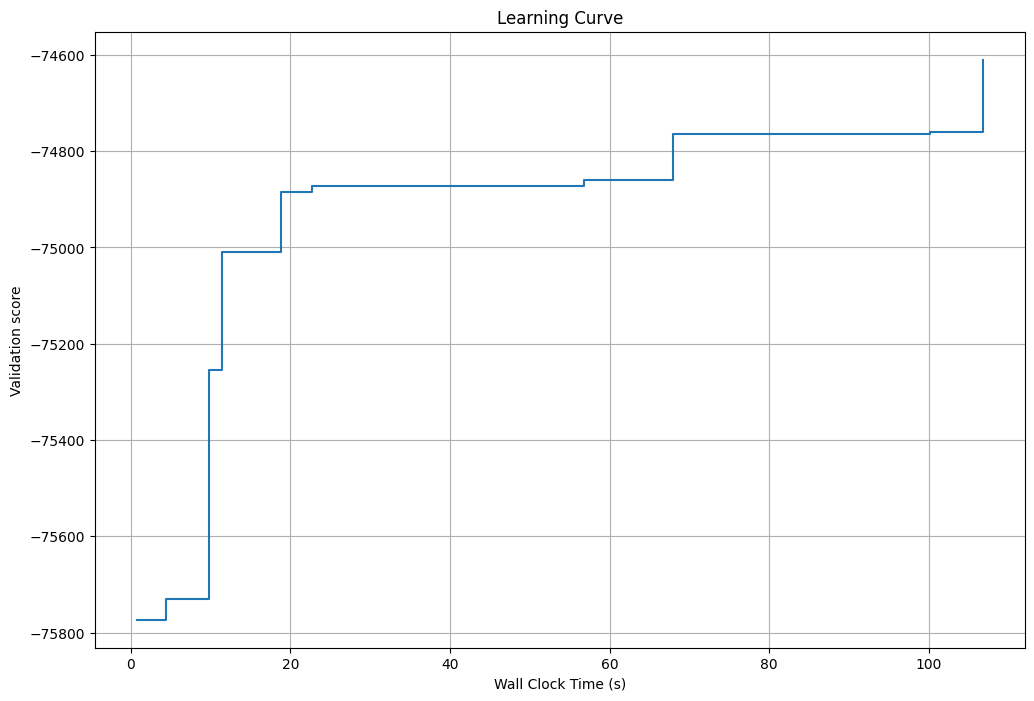

In [195]:
plt.figure(figsize=(12, 8))
plt.title("Learning Curve")
plt.xlabel("Wall Clock Time (s)")
plt.ylabel("Validation score")
plt.step(time_history, 1 - np.array(best_valid_loss_history), where="post")
plt.grid()
plt.show()

In [196]:
with mlflow.start_run() as run:
    run_id = run.info.run_id
    mlflow.log_params(automl.best_config_per_estimator)
    mlflow.log_artifact('output')

print(run_id)

2024/09/02 14:16:19 INFO mlflow.tracking._tracking_service.client: 🏃 View run bold-dolphin-22 at: https://dagshub.com/SantanuK/Kaggle-Competitions-Lab.mlflow/#/experiments/7/runs/a955222934c048d89437f1f62ca42607.
2024/09/02 14:16:19 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/SantanuK/Kaggle-Competitions-Lab.mlflow/#/experiments/7.


a955222934c048d89437f1f62ca42607


## Rough Space

In [ ]:
sys_str = ['2.7L V6 24V PDI DOHC Twin Turbo', '5.2L V10 40V PDI DOHC',
       '518.0HP Electric Motor Electric Fuel System',
       '3.6L V6 24V GDI DOHC', '4.0L V8 32V GDI DOHC Twin Turbo',
       '835.0HP Electric Motor Electric Fuel System',
       '5.7L V8 16V MPFI OHV', '3.0L V6 24V GDI DOHC Twin Turbo',
       '3.8L V8 32V MPFI DOHC Twin Turbo',
       '3.4L V6 24V PDI DOHC Twin Turbo Hybrid',
       '3.5L V6 24V PDI DOHC Twin Turbo', '2.0L I4 16V PDI DOHC Turbo',
       '2.4L I4 16V GDI DOHC', '2.0 Liter DOHC Turbo',
       '3.6L V6 24V MPFI DOHC', '6.0L V8 16V MPFI OHV Flexible Fuel',
       '2.0L I4 16V GDI DOHC Turbo', '2.3L I4 16V GDI DOHC Turbo',
       '670.0HP Electric Motor Electric Fuel System',
       '5.3L V8 16V GDI OHV',
       '425.0HP Electric Motor Electric Fuel System', '2.0 Liter',
       '3.0L V6 24V GDI DOHC Turbo', '3.8L V6 24V GDI DOHC',
       '3.8L H6 24V GDI DOHC Twin Turbo', '2.0 Liter Turbo',
       '455.0HP Electric Motor Electric Fuel System', '3.0 Liter Turbo',
       '2.0 Liter TFSI', '3.5 Liter', '2.5L H4 16V MPFI DOHC',
       '4.4L V8 32V GDI DOHC Twin Turbo', '5.6 Liter',
       '4.6L V8 32V MPFI DOHC', '4.0L V8 32V MPFI DOHC Twin Turbo',
       '2.5L I4 16V GDI DOHC', '3.6L V6 24V MPFI DOHC Hybrid',
       '2.0L I4 16V GDI SOHC Turbo', '1.5L I3 12V PDI DOHC Turbo',
       '5.0L V8 32V GDI DOHC Supercharged', '5.0 Liter',
       '557.0HP Electric Motor Electric Fuel System',
       '4.0L H6 24V GDI DOHC',
       '200.0HP Electric Motor Electric Fuel System',
       '6.3L V12 48V GDI DOHC', '6.7L I6 24V DDI OHV Turbo Diesel',
       '3.4L H6 24V MPFI DOHC', '2.7L V6 24V GDI DOHC Twin Turbo', '–',
       '3.6 Liter DOHC', '232.0HP 1.3L Rotary engine Gasoline Fuel',
       '3.6 Liter SIDI DOHC', '2.0L I4 16V GDI DOHC Turbo Hybrid',
       '5.0L V8 32V PDI DOHC', '3.0L H6 24V GDI DOHC Twin Turbo',
       '3.5L V6 24V PDI DOHC', '6.4L V8 16V MPFI OHV',
       '3.6L V6 24V MPFI DOHC Flexible Fuel',
       '6.7L V12 48V GDI DOHC Twin Turbo',
       '3.4L V6 24V PDI DOHC Twin Turbo', '4.0 Liter Twin Turbo',
       '3.8L H6 24V MPFI DOHC',
       '214.0HP Electric Motor Electric Fuel System',
       'Intercooled Turbo Diesel V-8 6.7 L/406',
       '778.0HP Electric Motor Electric Fuel System',
       '2.5L I4 16V PDI DOHC Turbo', '4.0 Liter TFSI',
       '3.3L V6 24V GDI DOHC', '3.6 Liter', '2.5L I4 16V GDI DOHC Turbo',
       '271.0HP Electric Motor Electric Fuel System', '3.5 Liter DOHC',
       '4.7L 8 Cylinder Engine Gasoline Fuel', '5.7L V8 32V MPFI DOHC',
       '3.0 Liter DOHC Twin Turbo', '2.0L I4 16V GDI DOHC',
       '2.0L I4 16V MPFI DOHC', '3.0L I6 24V DDI DOHC Turbo Diesel',
       '482.0HP Electric Motor Electric Fuel System',
       '2.5L I4 16V PDI DOHC', '6.2L V8 16V GDI OHV',
       '3.0L I6 24V GDI DOHC Turbo', '3.5L V6 24V GDI SOHC',
       '480.0HP Electric Motor Electric Fuel System',
       '5.6L V8 32V GDI DOHC', '3.5L V6 24V MPFI DOHC',
       '2.5L H4 16V GDI DOHC',
       '362.0HP Electric Motor Electric Fuel System',
       '201.0HP Electric Motor Electric Fuel System', '6.4 Liter', 'V6',
       '563.0HP Electric Motor Electric Fuel System', '3.0 Liter',
       '3.5L V6 24V PDI DOHC Hybrid', '6.0L V8 16V MPFI OHV',
       '2.4L I4 16V MPFI DOHC',
       '2.0L I4 16V GDI DOHC Turbo Flexible Fuel',
       '5.2L V10 40V GDI DOHC', '1.3L I3 12V GDI DOHC Turbo',
       '2.0L I4 16V GDI DOHC Hybrid', '3.0 Liter TFSI',
       '6.5L V12 48V MPFI DOHC', '1.6L I4 16V GDI DOHC Turbo',
       '3.5 Liter SOHC',
       '170.0HP 0.65L Electric Motor Electric Fuel System',
       '3.0 Liter Twin Turbo', '5.4 Liter', '3.6L V6 GDI DOHC',
       '2.5 Liter', '534.0HP Electric Motor Electric Fuel System',
       'Standard Range Battery', '4.7 Liter Twin Turbo', '4.6 Liter',
       '266.0HP Electric Motor Electric Fuel System',
       '3.5L V6 24V GDI DOHC Twin Turbo',
       '6.7L V8 32V DDI OHV Turbo Diesel', '3.5L 24V SOHC I-VTEC V6',
       '3.2L V6 24V MPFI DOHC', '1.5L I4 16V GDI DOHC Turbo',
       '2.5L I4 16V MPFI DOHC', '2.9L V6 24V GDI DOHC Twin Turbo',
       '2.4 Liter', '2.5L I4 16V',
       '355.0HP Electric Motor Electric Fuel System',
       '422.0HP Electric Motor Electric Fuel System', '4.0 Liter',
       '3.0 Liter GTDI', '3.5L V6 24V PDI DOHC Twin Turbo Hybrid',
       '346.0HP Electric Motor Electric Fuel System', '4.4 Liter',
       '2.4L H4 16V GDI DOHC Turbo',
       '6.0L 8 Cylinder Engine Gasoline Fuel',
       '6.0L W12 48V PDI DOHC Twin Turbo', '4.4 Liter Twin Turbo',
       '1020.0HP Electric Motor Electric Fuel System',
       '12 Cylinder Engine', '4.0L V6 24V MPFI DOHC',
       '3.2L H6 24V MPFI DOHC', '6.8L V12 48V GDI DOHC Twin Turbo',
       '2.4L I4 16V MPFI SOHC',
       'Intercooled Turbo Premium Unleaded I-4 2.0 L/122',
       '295.0HP Electric Motor Electric Fuel System',
       '1.3L I3 12V MPFI DOHC Turbo', '4.2L V8 32V GDI DOHC',
       '107.0HP Electric Motor Electric Fuel System',
       '2.4L I4 16V PDI DOHC Turbo', '6.6L V8 32V DDI OHV Turbo Diesel',
       '320.0HP Electric Motor Electric Fuel System', '5.4 Liter SC DOHC',
       '329.0HP Electric Motor Electric Fuel System',
       '6.6L V8 16V GDI OHV', '2.7 Liter DOHC Turbo',
       '4.2L V8 32V GDI DOHC Twin Turbo',
       '3.0L V6 24V PDI DOHC Twin Turbo', '6.2 Liter', '4.0L',
       '1.6L I4 16V GDI DOHC Turbo Hybrid', '1.5L I3 12V GDI DOHC Turbo',
       '536.0HP Electric Motor Electric Fuel System',
       '212.0HP 1.3L Rotary engine Gasoline Fuel',
       '5.3L V8 16V MPFI OHV Flexible Fuel', '6.6 Liter Twin Turbo',
       '403.0HP 2.0L Electric Motor Electric Fuel System',
       '2.5L I4 16V MPFI DOHC Hybrid', '3.0 Liter SC ULEV',
       '3.5L V6 24V GDI DOHC', 'I4', '2.5L',
       '3.0L I6 24V GDI DOHC Twin Turbo', '2.0 Liter Supercharged',
       '2.0 Liter TSI', '5.0L 8 Cylinder',
       '416.0HP Electric Motor Electric Fuel System',
       '2.0L I4 16V MPFI DOHC Hybrid', 'V8',
       '6.2L V8 16V MPFI SOHC Flexible Fuel', '2.0 Liter DOHC T/C',
       '3.0L V6 24V GDI DOHC Supercharged',
       '3.8L V8 32V GDI DOHC Twin Turbo',
       '3.8L V6 24V MPFI DOHC Twin Turbo', '3.0L',
       '375.0HP Electric Motor Electric Fuel System', '4.0 Liter Turbo',
       '1.2L I3 12V GDI DOHC Turbo',
       '691.0HP Electric Motor Electric Fuel System',
       '3.9L V8 32V GDI DOHC Twin Turbo', '2.7L I4 16V GDI DOHC Turbo',
       '5.7 Liter', '1.6L I4 16V MPFI DOHC',
       '2.5L 4 Cylinder Engine Gasoline Fuel',
       '5.2L V12 48V GDI DOHC Twin Turbo',
       '8.0L W16 64V GDI DOHC Twin Turbo', '3.0 Liter DOHC Turbo',
       '120 AH', '417.0HP Electric Motor Electric Fuel System',
       '2.9 Liter Turbo', '1.6L I4 16V GDI DOHC Hybrid',
       '2.5L I4 16V PDI DOHC Hybrid', '4.4 Liter DOHC Twin Turbo',
       '6.2L V8 16V GDI OHV Supercharged',
       '147.0HP Electric Motor Electric Fuel System',
       '6.8L V12 48V GDI DOHC', 'Battery Electric',
       '151.0HP Electric Motor Hydrogen Fuel',
       '182.0HP Electric Motor Hydrogen Fuel',
       '616.0HP Electric Motor Electric Fuel System', '5.3 Liter',
       '3.2L V6 18V MPFI SOHC', '2.0L I4 16V GDI DOHC Flexible Fuel',
       '500.0HP Electric Motor Electric Fuel System',
       '3.0L V6 Cylinder Engine Diesel Fuel', '5.5 Liter', '1.8 Liter',
       '620.0HP Electric Motor Electric Fuel System', '1.5 Liter Turbo',
       '321.0HP Electric Motor Electric Fuel System', '3.5 Liter GTDI',
       '6.4L V8 32V DDI OHV Twin Turbo Diesel',
       '111.2Ah / FR 70kW / RR 160kW (697V)',
       '533.0HP Electric Motor Electric Fuel System',
       '5.8L V8 32V MPFI DOHC Supercharged', '1.4L I4 16V GDI DOHC Turbo',
       'Dual AC Electric Motors', '4.4 Liter GDI DOHC Twin Turbo',
       '6.2L V8 32V MPFI DOHC',
       '290.0HP Electric Motor Electric Fuel System',
       '1.6L I4 16V GDI DOHC',
       '402.0HP Electric Motor Electric Fuel System',
       '111.0HP Electric Motor Electric Fuel System',
       '3.8L V6 12V MPFI OHV',
       '115.0HP Electric Motor Electric Fuel System']